# Shopper similarity analysis

This notebook tries to find if there are similarities in shopper behaviour using network analysis.

## Theory

**Girvan Newman**

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step. As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.

**Edge betweenness centrality**

Compute betweenness centrality for edges.

Betweenness centrality of an edge e is the sum of the fraction of all-pairs shortest paths that pass through e:

$$ c_b(e) = \sum_{s, t \ \in V} \frac{\sigma(s, t \mid e)}{\sigma(s, t)} $$


## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import copy

from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils
from msci.analysis.networks import *
from msci.utils.plot import create_count_of_shoppers_gif, create_count_of_shoppers_image
from msci.utils.plot import plot_path_jn

In [4]:
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman

## Import raw data

In [5]:
signal_df = utils.import_signals('Mall of Mauritius', version=3, signal_type=1)

In [6]:
from msci.cleaning.store_ids import clean_store_id

In [7]:
cleaner_signal_df = clean_store_id(signal_df[signal_df.store_id.notnull()])

HBox(children=(IntProgress(value=0, max=266), HTML(value='')))

## Method

We want to create a matrix which will enable us to determine how similar two shoppers are. We can then perform various measures on this dataset such as:
- community detection
- xxx

Create a shopper normalised similarity matrix:
- get the signals from the mall
- create a pivot data which contains shopper on the x-axis and shops on the y-axis and the signal count as the value
- turn all signal counts to 1
- for every pair of shoppers $Aij$ calculate the number of stores that they both went to
- divide each connection by the total number of shops visited for the $i$th shopper

This has now created a weighted directional network $A$ which gives the shopper $i$'s similarity to shopper $j$. The similarity is calculated by the number of shops they both went to divide by the number of shops shopper $i$ went to.

## Get data

In [8]:
shopper_shop_pivot = create_shopper_shop_pivot(cleaner_signal_df)

In [9]:
analysis_mac_addresses = shopper_shop_pivot.index.drop_duplicates().tolist()[5000:5010]

In [10]:
shopper_shop_pivot = shopper_shop_pivot[shopper_shop_pivot.index.isin(analysis_mac_addresses)]

In [11]:
shopper_similarity_df = create_similarity_matrix(shopper_shop_pivot, num_entities=51, skip_entities=0)

## Create network

In [ ]:
G = nx.from_numpy_matrix(shopper_similarity_df.as_matrix(), create_using=nx.MultiDiGraph())
# G = nx.relabel_nodes(G, dict(enumerate(shopper_similarity_df.columns)))

In [ ]:
comp = girvan_newman(G)
communities = tuple(sorted(c) for c in next(comp))

In [ ]:
communities

In [ ]:
shopper_similarity_matrix = shopper_similarity_df.as_matrix()
shopper_similarity_matrix_binary = copy.deepcopy(shopper_similarity_matrix)
shopper_similarity_matrix_binary[np.where(shopper_similarity_matrix_binary > 0)] = 1
shopper_similarity_matrix_binary

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
pos = nx.spectral_layout(G)
nx.draw_spectral(G)
labels = {i : i for i in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=15)
plt.savefig('destination_path.png', format='png', dpi=1000)
plt.show()

In [ ]:
G.edges(data=True)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
plot_path_jn(signal_df, communities[0], axes=ax, scatter=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
plot_path_jn(signal_df, communities[1], axes=ax, scatter=False)

In [ ]:
for shopper in communities[1]:
    print(signal_df[(signal_df.mac_address == shopper) & signal_df.store_id.str.contains('B')].store_id.unique())

Two sets of paths on two maps of Mall of Mauritius. The each set of paths shows a different community detected by the Girvan–Newman algorithm. Each paths is connected to the next via the number of stories they both went to divide by the number of stores that path went to.

## Investigate deeper

In [ ]:
import itertools

In [ ]:
G = nx.from_numpy_matrix(shopper_similarity_df.as_matrix(), create_using=nx.MultiDiGraph())
# G = nx.relabel_nodes(G, dict(enumerate(shopper_similarity_df.columns)))

In [ ]:
k = 50
comp = girvan_newman(G)
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities)) 

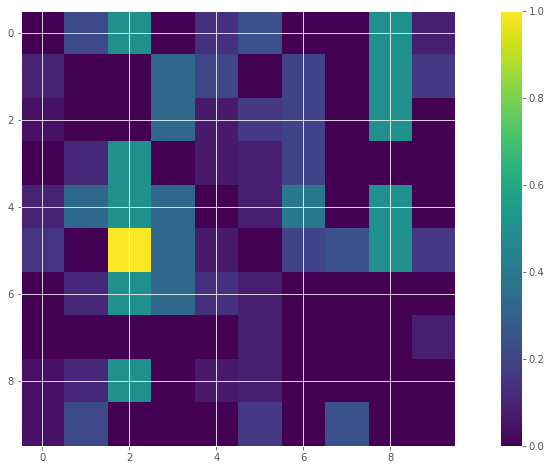

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
plt.imshow(shopper_similarity_df.as_matrix())
plt.colorbar()

## Haussdorf comparison

In [12]:
from msci.analysis.complexity import pairwise_haussdorf_fast, position_dictionary, matrix_correlation

In [13]:
pos_dict = position_dictionary(
    cleaner_signal_df[cleaner_signal_df.mac_address.isin(analysis_mac_addresses)], 
    list_type=True
)
sub = pos_dict
ph = pairwise_haussdorf_fast(sub, plot=False)

0.10929250717163086


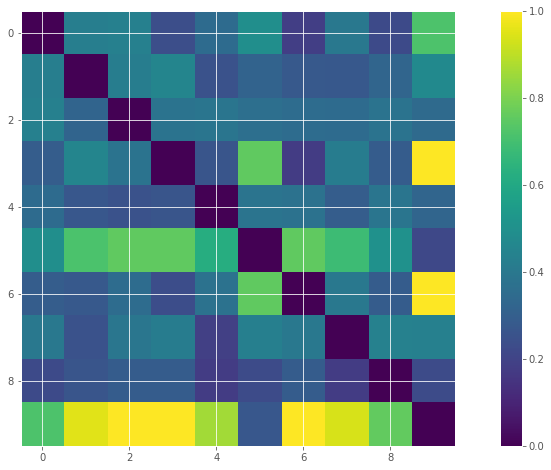

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
plt.imshow(ph)
plt.colorbar()

In [16]:
matrix_correlation(shopper_similarity_df.as_matrix(), ph)

array([[ 1.        ,  0.10794897],
       [ 0.10794897,  1.        ]])